# LSTM - All Sites

In this notebook, we train an LSTM model to predict dry (0) or wet (1) for a given HJ Andrews River Site 3 days after a given date, using a 30-day sliding window of features.

The dataset combines HOBO sensor readings with discretized discharge values. We track the source of each sample (HOBO vs discretized) and report 3 validations: the full validation set, HOBO-only, and discretized-only.

We apply ADASYN to the training data and use a random train-test split. Sequences are created per site to avoid cross-site boundary contamination.

At the bottom of the notebook, we provide a function for practitioners to run inference with our trained models for an inputted site-date combination.

## Imports

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report
)
from imblearn.over_sampling import ADASYN
import optuna
from optuna.visualization.matplotlib import plot_contour, plot_parallel_coordinate
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

## Data Preprocessing

In [23]:
# Data Paths
OBS_PATH = "/Users/michaelmurphy/Desktop/usgs_data/obs.parquet"
STATIC_PATH = "/Users/michaelmurphy/Desktop/usgs_data/static_vars.parquet"
DEGREES_PATH = "/Users/michaelmurphy/Desktop/usgs_data/degrees.parquet"

# Load datasets
static_vars_df = pd.read_parquet(STATIC_PATH)
obs_df = pd.read_parquet(OBS_PATH)
degrees = pd.read_parquet(DEGREES_PATH)

obs_df

,NHDPlusID,SiteIDCode,Date,variable,value
0,55000900130309,GSWS01,1980-01-01,Discharge_CMS,0.045505
1,55000900130309,GSWS01,1980-01-02,Discharge_CMS,0.043410
2,55000900130309,GSWS01,1980-01-03,Discharge_CMS,0.048592
3,55000900130309,GSWS01,1980-01-04,Discharge_CMS,0.061872
4,55000900130309,GSWS01,1980-01-05,Discharge_CMS,0.276599
...,...,...,...,...,...
160731,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Threshold,0.000000
160732,55000900130309,WDLookMcRaeID1,2020-07-08,MaxDepth_Censor,1.000000
160733,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_cm,51.816000
160734,55000900130309,WDLookMcRaeID1,2020-08-12,MaxDepth_Threshold,0.000000


In [24]:
# Pivot static vars (each variable as a column)
static_wide = static_vars_df.pivot(
    index='NHDPlusID', columns='variable', values='value'
).reset_index()

# Pivot obs (Date as rows, variable as columns)
obs_wide = obs_df.pivot_table(
    index=['NHDPlusID', 'Date'], columns='variable', values='value'
).reset_index()

# Merge static features into each site's obs
merged_df = obs_wide.merge(static_wide, on='NHDPlusID', how='left')
merged_df = merged_df.merge(degrees, on='NHDPlusID', how='left')

# Sort and forward-fill
merged_df = merged_df.sort_values(['NHDPlusID', 'Date']).ffill()
merged_df.head()

,NHDPlusID,Date,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm,ArbolateSu,AreaSqKm,...,curv_mean,curv_median,elev_max_cm,elev_mean_cm,elev_median_cm,elev_min_cm,slp_mean_pct,slp_median_pct,In-degree,Out-degree
0,55000900027171,2020-08-12,NaN,0.00,NaN,0.0,0.0,0.0,0.100818,0.0017,...,63.946892,63.048618,66223.0,58209.588235,57898.0,51722.0,63.946892,63.048618,0.0,1.0
1,55000900027173,2020-08-12,NaN,0.75,NaN,1.0,0.0,7.0,0.297666,0.1235,...,42.080586,41.399857,103022.0,88853.689879,88575.0,74487.0,42.080586,41.399857,1.0,1.0
2,55000900027174,2020-08-12,NaN,1.00,NaN,1.0,0.0,5.5,0.410513,0.0923,...,55.872930,56.605061,96559.0,79958.395450,80669.0,63278.0,55.872930,56.605061,0.0,1.0
3,55000900027177,2020-09-03,NaN,0.50,NaN,1.0,0.0,1.0,0.366996,0.1216,...,63.409000,65.848724,72273.0,60448.368421,60738.5,46037.0,63.409000,65.848724,0.0,1.0
4,55000900027180,2020-09-02,NaN,0.50,NaN,1.0,0.0,11.0,1.082607,0.0592,...,21.379627,22.186161,55631.0,49135.785473,48683.0,46107.0,21.379627,22.186161,2.0,1.0


In [25]:
# Create discharge-based wet/dry and combine with HOBO sensor readings
DRY_THRESHOLD = 0.00014
merged_df["wetdry_discharge"] = (merged_df["Discharge_CMS"] >= DRY_THRESHOLD).astype(int)

# Track which samples come from HOBO vs discretized discharge
# is_hobo=1 when HoboWetDry0.05 is NaN (these are the real HOBO sensor sites)
# is_hobo=0 when HoboWetDry0.05 is not NaN (these are the discretized discharge sites)
merged_df["is_hobo"] = merged_df["HoboWetDry0.05"].isna().astype(int)

merged_df["wetdry_prev"] = merged_df["HoboWetDry0.05"].fillna(merged_df["wetdry_discharge"])

merged_df["wetdry_final"] = merged_df.groupby('NHDPlusID')["wetdry_prev"].shift(-3)
merged_df = merged_df.dropna(subset='wetdry_final')

# Drop irrelevant and other target columns
merged_df = merged_df.drop(columns=["wetdry_discharge", "FromNode", "ToNode", "Flow_Status", "HoboWetDry0.05", "Discharge_CMS"])

print("Final wet/dry distribution:")
print(merged_df["wetdry_final"].value_counts())
print(f"\nSource distribution:")
print(f"  HOBO: {merged_df['is_hobo'].sum()}")
print(f"  Discretized: {(merged_df['is_hobo'] == 0).sum()}")

Final wet/dry distribution:
wetdry_final
1.0    125423
0.0     32784
Name: count, dtype: int64

Source distribution:
  HOBO: 12213
  Discretized: 145994


In [26]:
target_col = "wetdry_final"

# Fill remaining NaNs
df = merged_df.copy()
df = df.ffill().bfill().fillna(0)

# Identify feature columns (numeric, excluding target and source tracker)
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns
                if c not in [target_col, 'is_hobo']]

# Scale features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

print(f"Features ({len(feature_cols)}): {feature_cols}")
print(f"Samples: {len(df)}")

Features (23): ['MaxDepth_Censor', 'MaxDepth_Threshold', 'MaxDepth_cm', 'ArbolateSu', 'AreaSqKm', 'LengthKM', 'Slope', 'TotDASqKm', 'aspect_ne_pct', 'aspect_nw_pct', 'aspect_se_pct', 'aspect_sw_pct', 'curv_mean', 'curv_median', 'elev_max_cm', 'elev_mean_cm', 'elev_median_cm', 'elev_min_cm', 'slp_mean_pct', 'slp_median_pct', 'In-degree', 'Out-degree', 'wetdry_prev']
Samples: 158207


In [27]:
# Create 30-day sliding window sequences per site
seq_len = 30

def create_sequences_by_site(df, site_col, feature_cols, target_col, source_col, seq_len=30):
    """Create sliding window sequences grouped by site, tracking sample source."""
    X, y, sources = [], [], []
    for _, group in df.groupby(site_col):
        if len(group) <= seq_len:
            continue
        features = group[feature_cols].values
        labels = group[target_col].values
        src = group[source_col].values
        for i in range(len(group) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(labels[i + seq_len - 1])
            sources.append(src[i + seq_len - 1])  # source of the target label
    return np.array(X), np.array(y), np.array(sources)

X, y, sources = create_sequences_by_site(
    df, 'NHDPlusID', feature_cols, target_col, 'is_hobo', seq_len=seq_len
)
print(f"Sequences: {X.shape}, Labels: {y.shape}")
print(f"Class distribution — Wet: {int((y > 0.5).sum())}, Dry: {int((y <= 0.5).sum())}")
print(f"Source — HOBO: {int(sources.sum())}, Discretized: {int((sources == 0).sum())}")

Sequences: (157177, 30, 23), Labels: (157177,)
Class distribution — Wet: 124536, Dry: 32641
Source — HOBO: 12184, Discretized: 144993


In [28]:
# Random train-test split (BEFORE ADASYN)
X_train, X_val, y_train, y_val, src_train, src_val = train_test_split(
    X, y, sources, test_size=0.2, shuffle=True, random_state=42
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")
print(f"Val source — HOBO: {int(src_val.sum())}, Discretized: {int((src_val == 0).sum())}")

# ADASYN on training data only (flatten 3D -> 2D, resample, reshape back)
n, T, d = X_train.shape
X_flat = X_train.reshape(n, T * d)
adasyn = ADASYN(random_state=42)
X_flat_res, y_train_res = adasyn.fit_resample(X_flat, y_train.astype(int))
X_train_res = X_flat_res.reshape(-1, T, d)

print(f"\nOriginal train class counts: {np.bincount(y_train.astype(int))}")
print(f"After ADASYN: {np.bincount(y_train_res.astype(int))}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

print(f"\nX_train_tensor: {X_train_tensor.shape}, X_val_tensor: {X_val_tensor.shape}")

Train: (125741, 30, 23), Val: (31436, 30, 23)
Val source — HOBO: 2342, Discretized: 29094

Original train class counts: [26122 99619]
After ADASYN: [99607 99619]

X_train_tensor: torch.Size([199226, 30, 23]), X_val_tensor: torch.Size([31436, 30, 23])


## Hyperparameter Selection

In [29]:
# Use a small random subset for faster Optuna search
HP_SAMPLE_SIZE = 10000
hp_train_idx = np.random.choice(len(X_train_tensor), min(HP_SAMPLE_SIZE, len(X_train_tensor)), replace=False)
hp_val_idx = np.random.choice(len(X_val_tensor), min(HP_SAMPLE_SIZE, len(X_val_tensor)), replace=False)
X_hp_train = X_train_tensor[hp_train_idx]
y_hp_train = y_train_tensor[hp_train_idx]
X_hp_val = X_val_tensor[hp_val_idx]
y_hp_val = y_val_tensor[hp_val_idx]
print(f"Optuna subset — Train: {X_hp_train.shape}, Val: {X_hp_val.shape}")

# LSTM model for Optuna (with sigmoid output)
class LSTMModelHP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.sigmoid(out)

# Optuna objective
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    dropout     = trial.suggest_float("dropout", 0.0, 0.4)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs      = 3

    model = LSTMModelHP(
        input_size=X_hp_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    )
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(TensorDataset(X_hp_train, y_hp_train), batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_hp_val).squeeze(-1).cpu().numpy()
        val_true = y_hp_val.squeeze(-1).cpu().numpy()

    if len(np.unique(val_true)) < 2:
        return 1.0

    auc = roc_auc_score(val_true, val_preds)
    return 1 - auc  # minimize (1 - AUC)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=7)

print("\nBest Hyperparameters:")
print(study.best_params)
print(f"Best Validation AUC: {1 - study.best_value:.4f}")

[I 2026-02-16 21:04:38,425] A new study created in memory with name: no-name-d1ed9feb-0df8-423d-8206-e68fb2100218


Optuna subset — Train: torch.Size([10000, 30, 23]), Val: torch.Size([10000, 30, 23])


[I 2026-02-16 21:05:38,604] Trial 0 finished with value: 6.178371809495431e-05 and parameters: {'hidden_size': 34, 'num_layers': 2, 'dropout': 0.32666647510493196, 'lr': 0.004853039551886833, 'batch_size': 16}. Best is trial 0 with value: 6.178371809495431e-05.
[I 2026-02-16 21:08:35,797] Trial 1 finished with value: 0.001336257516506123 and parameters: {'hidden_size': 117, 'num_layers': 3, 'dropout': 0.10095962095469574, 'lr': 0.0027318892567802615, 'batch_size': 64}. Best is trial 0 with value: 6.178371809495431e-05.
[I 2026-02-16 21:09:50,828] Trial 2 finished with value: 6.892207596254085e-05 and parameters: {'hidden_size': 97, 'num_layers': 1, 'dropout': 0.3658834686650545, 'lr': 0.0003502106432402838, 'batch_size': 32}. Best is trial 0 with value: 6.178371809495431e-05.
[I 2026-02-16 21:16:52,544] Trial 3 finished with value: 6.018374133143212e-05 and parameters: {'hidden_size': 109, 'num_layers': 3, 'dropout': 0.2220480563955669, 'lr': 0.0008550618344393416, 'batch_size': 16}. B


Best Hyperparameters:
{'hidden_size': 121, 'num_layers': 2, 'dropout': 0.1344478074520112, 'lr': 0.000528738495965696, 'batch_size': 32}
Best Validation AUC: 0.9999


/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_4713/1309970182.py:2: ExperimentalWarning: optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_contour(


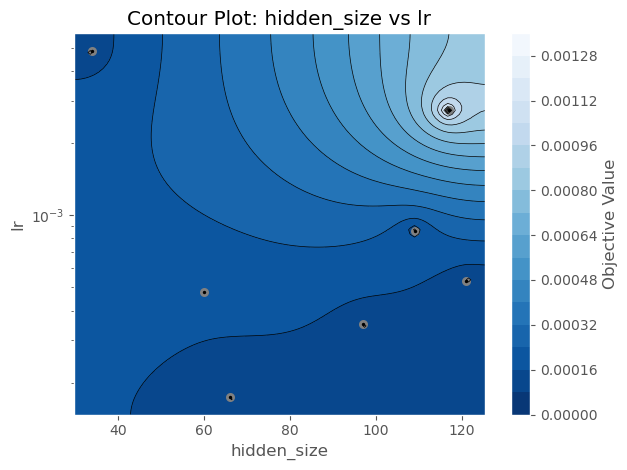

In [30]:
# Contour plot of hyperparameter interactions
fig = plot_contour(
    study,
    params=["hidden_size", "lr"]
)
plt.title("Contour Plot: hidden_size vs lr")
plt.tight_layout()
plt.show()

/var/folders/jd/4sjpm6q97knfqgwsf50gr3jh0000gn/T/ipykernel_4713/185385442.py:2: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_parallel_coordinate(


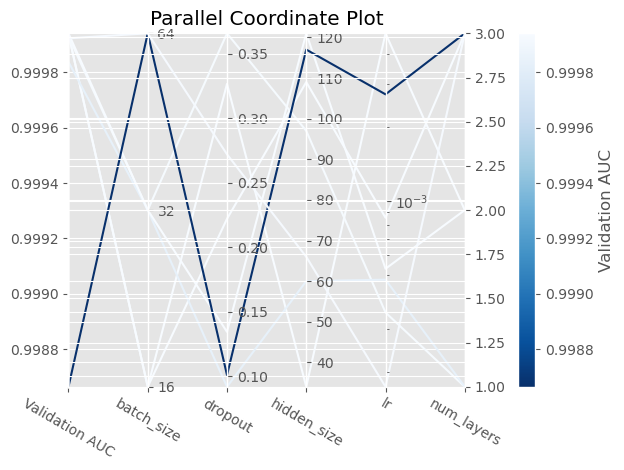

In [31]:
# Parallel coordinate plot
fig = plot_parallel_coordinate(
    study,
    params=["hidden_size", "num_layers", "dropout", "lr", "batch_size"],
    target=lambda t: 1.0 - t.value,
    target_name="Validation AUC"
)
plt.tight_layout()
plt.show()

## Model Training

In [32]:
# Toggle: use Optuna-found hyperparameters or defaults
USE_OPTUNA = True

if USE_OPTUNA:
    best = study.best_params
    hidden_size = best['hidden_size']
    num_layers = best['num_layers']
    dropout = best['dropout']
    lr = best['lr']
    batch_size = best['batch_size']
    print(f"Using Optuna params: hidden_size={hidden_size}, num_layers={num_layers}, "
          f"dropout={dropout:.4f}, lr={lr:.6f}, batch_size={batch_size}")
else:
    hidden_size = 48
    num_layers = 1
    dropout = 0.2
    lr = 1e-4
    batch_size = 32
    print(f"Using default params: hidden_size={hidden_size}, num_layers={num_layers}, "
          f"dropout={dropout}, lr={lr}, batch_size={batch_size}")

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Define LSTM model (logits output for BCEWithLogitsLoss)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=len(feature_cols), hidden_size=hidden_size,
                  num_layers=num_layers, dropout=dropout)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0]))
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training with early stopping
best_val_loss = float("inf")
best_state = None
patience = 3
wait = 0
epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
            val_loss += criterion(logits, yb).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss={total_loss/len(train_loader):.4f} | Val Loss={val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict().copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)
print("Loaded best model state.")

Using Optuna params: hidden_size=121, num_layers=2, dropout=0.1344, lr=0.000529, batch_size=32
Epoch 1/15 | Train Loss=0.1025 | Val Loss=0.0899
Epoch 2/15 | Train Loss=0.0952 | Val Loss=0.0829


KeyboardInterrupt: 

## Metrics and Feature Importance

In [33]:
# Prediction helper
def get_predictions(model, X, y):
    """Get predictions for a set of inputs."""
    model.eval()
    X_t = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
    with torch.no_grad():
        logits = model(X_t).squeeze()
        logits = torch.nan_to_num(logits, nan=0.0, posinf=5.0, neginf=-5.0)
        probs = torch.sigmoid(logits).numpy()
    preds = (probs >= 0.5).astype(int)
    y_true = y.astype(int) if isinstance(y, np.ndarray) else y.squeeze().numpy().astype(int)
    return y_true, preds, probs

def print_metrics(name, y_true, y_pred, y_probs):
    print(f"\n{'='*50}")
    print(f"{name} (n={len(y_true)})")
    print(f"{'='*50}")
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else float('nan')
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC:  {roc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=['Dry', 'Wet'], digits=3))
    return acc, roc, f1

# Split validation set by source
hobo_mask = src_val == 1
disc_mask = src_val == 0

# 1. Full validation set
y_true_all, y_pred_all, y_probs_all = get_predictions(model, X_val, y_val)
acc_all, roc_all, f1_all = print_metrics("ALL VALIDATION (HOBO + Discretized)", y_true_all, y_pred_all, y_probs_all)

# 2. HOBO-only validation
y_true_hobo, y_pred_hobo, y_probs_hobo = get_predictions(model, X_val[hobo_mask], y_val[hobo_mask])
acc_hobo, roc_hobo, f1_hobo = print_metrics("HOBO-ONLY VALIDATION", y_true_hobo, y_pred_hobo, y_probs_hobo)

# 3. Discretized-only validation
y_true_disc, y_pred_disc, y_probs_disc = get_predictions(model, X_val[disc_mask], y_val[disc_mask])
acc_disc, roc_disc, f1_disc = print_metrics("DISCRETIZED-ONLY VALIDATION", y_true_disc, y_pred_disc, y_probs_disc)

# Summary table
results_df = pd.DataFrame({
    'Validation Set': ['All (HOBO + Disc)', 'HOBO Only', 'Discretized Only'],
    'N': [len(y_true_all), int(hobo_mask.sum()), int(disc_mask.sum())],
    'Accuracy': [acc_all, acc_hobo, acc_disc],
    'ROC-AUC': [roc_all, roc_hobo, roc_disc],
    'F1': [f1_all, f1_hobo, f1_disc]
})
print(f"\n{'='*50}")
print("Summary")
print('='*50)
print(results_df.to_string(index=False))


ALL VALIDATION (HOBO + Discretized) (n=31436)
Accuracy: 0.9293
ROC-AUC:  0.9554
F1 Score: 0.9534
              precision    recall  f1-score   support

         Dry      0.746     1.000     0.854      6519
         Wet      1.000     0.911     0.953     24917

    accuracy                          0.929     31436
   macro avg      0.873     0.955     0.904     31436
weighted avg      0.947     0.929     0.933     31436


HOBO-ONLY VALIDATION (n=2342)
Accuracy: 0.0594
ROC-AUC:  0.5054
F1 Score: 0.0213
              precision    recall  f1-score   support

         Dry      0.050     1.000     0.095       115
         Wet      1.000     0.011     0.021      2227

    accuracy                          0.059      2342
   macro avg      0.525     0.505     0.058      2342
weighted avg      0.953     0.059     0.025      2342


DISCRETIZED-ONLY VALIDATION (n=29094)
Accuracy: 0.9994
ROC-AUC:  0.9996
F1 Score: 0.9996
              precision    recall  f1-score   support

         Dry      0.9

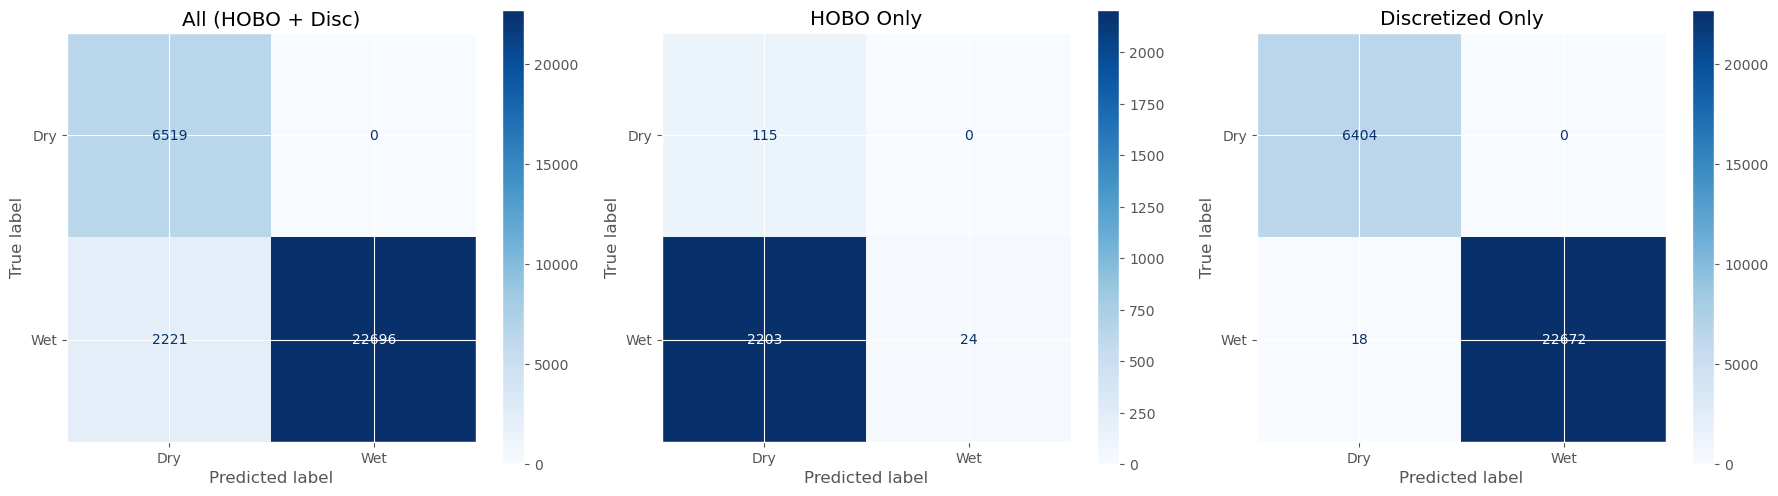

In [34]:
# Confusion matrices for all 3 validation sets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, y_t, y_p) in zip(axes, [
    ('All (HOBO + Disc)', y_true_all, y_pred_all),
    ('HOBO Only', y_true_hobo, y_pred_hobo),
    ('Discretized Only', y_true_disc, y_pred_disc)
]):
    cm = confusion_matrix(y_t, y_p, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dry', 'Wet'])
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    ax.set_title(f'{name}')

plt.tight_layout()
plt.show()

In [ ]:
# Permutation importance
def perm_importance(model, X_val_tensor, y_val, n_repeats=3):
    model.eval()
    base_preds = torch.sigmoid(model(X_val_tensor)).detach().cpu().numpy()
    base_f1 = f1_score(y_val, (base_preds > 0.5))

    importances = []
    for col in range(X_val_tensor.shape[2]):
        f1_scores = []
        for _ in range(n_repeats):
            X_permuted = X_val_tensor.clone()
            X_permuted[:, :, col] = X_val_tensor[:, :, col][torch.randperm(X_val_tensor.shape[0])]
            perm_preds = torch.sigmoid(model(X_permuted)).detach().cpu().numpy()
            f1_scores.append(f1_score(y_val, (perm_preds > 0.5)))
        importances.append(base_f1 - np.mean(f1_scores))

    return np.array(importances)

imps = perm_importance(model, X_val_tensor, y_val.astype(int))

importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": imps
})
importance['Abs_Importance'] = importance['Importance'].abs()
importance = importance.sort_values('Abs_Importance', ascending=False)
importance['Importance_Scaled'] = importance['Abs_Importance'] / importance['Abs_Importance'].max()

print(importance[['Feature', 'Importance']].to_string(index=False))

top10 = importance.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10['Feature'][::-1], top10['Importance_Scaled'][::-1])
ax.set_xlabel('Feature Importance (0-1 Scaled)')
ax.set_title('Top 10 Feature Importances - LSTM (Permutation)')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Inference

In [ ]:
def predict_site_date_lstm(model, scaler, site_df, seq_len, site_id, date, target_col="wetdry_final", days_ahead=3):
    """
    Predict wet/dry status for a given site and date using LSTM.
    
    Parameters:
    -----------
    model : LSTMModel
        Trained LSTM model
    scaler : StandardScaler
        Fitted scaler for feature normalization
    site_df : pd.DataFrame
        Complete dataset for the site with all features
    seq_len : int
        Sequence length used in training (e.g., 30)
    site_id : str
        Site identifier (e.g., "55000900061097")
    date : str
        Date in format "YYYY-MM-DD"
    target_col : str
        Target column name
    
    Returns:
    --------
    str : Prediction result with probability
    """
    date = pd.to_datetime(date).date()
    site_id = str(site_id)
    
    # Get site data
    site_data = site_df[site_df["NHDPlusID"] == site_id].sort_values("Date")
    
    if site_data.empty:
        return f"No data found for Site {site_id}"
    
    # Find the date index
    date_idx = site_data[site_data["Date"] == date].index
    
    if len(date_idx) == 0:
        return f"No data found for Site {site_id} on {date}"
    
    date_idx = date_idx[0]
    date_pos = site_data.index.get_loc(date_idx)
    
    # Check if we have enough history
    if date_pos < seq_len:
        return f"Not enough historical data (need {seq_len} days) for {date}"
    
    # Extract sequence
    seq_data = site_data.iloc[date_pos - seq_len:date_pos]
    
    # Prepare features
    df_numeric = seq_data.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')
    seq_scaled = scaler.transform(df_numeric)
    
    # Convert to tensor
    seq_tensor = torch.tensor(seq_scaled, dtype=torch.float32).unsqueeze(0)  # (1, seq_len, features)
    
    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(seq_tensor)
        prob = torch.sigmoid(logits).item()
    
    pred_class = 1 if prob >= 0.5 else 0
    
    return f"Site {site_id}, {days_ahead} days after {date}: {'DRY' if pred_class == 0 else 'WET'}, (P(wet)={prob:.4f})"

In [ ]:
# Example inference
predict_site_date_lstm(
    model=model,
    scaler=scaler,
    site_df=merged_df.drop(columns=["is_hobo"]),
    seq_len=30,
    site_id="55000900272714",
    date="2020-10-18",
    target_col="wetdry_final"
)

'Site 55000900272714 on 2020-10-18: WET, (P(wet)=0.9994)'